## Oliwier Misztal   --------------   December 9, 2025
## Arthur Murphy
## Javi Jorge
# Molecular Modeling - Monte Carlo Methods

In [4]:
import numpy as np
from numba import njit
import time

# At first, we implement functions that are compiled with Numba for speed.

@njit
def create_nbr(L):
    """
    Creates the neighbor table for a 2D square lattice.
    Returns an array of shape (N, 4).
    """
    N = L * L
    nbr = np.zeros((N, 4), dtype=np.int64)
    
    # Pre-compute shifts (Periodic Boundaries)
    ip = np.arange(L) + 1
    im = np.arange(L) - 1
    ip[L - 1] = 0
    im[0] = L - 1
    
    for y in range(L):
        for x in range(L):
            i = x + y * L
            nbr[i, 0] = ip[x] + y * L   # Right neighbor
            nbr[i, 1] = im[x] + y * L   # Left neighbor
            nbr[i, 2] = x + ip[y] * L   # Up neighbor
            nbr[i, 3] = x + im[y] * L   # Down neighbor
            
    return nbr

@njit
def precompute_exponentials(T, nbr):
    """
    Analyzes the neighbor table to find 'z' (coordination number)
    and pre-computes the exponential table for all possible
    positive Delta E values.
    """
    beta = 1.0 / T
    
    # We analyze neighbors (nbr) to find 'z'
    # We assume a regular lattice where every site has the same number of neighbors.
    z = nbr.shape[1]  
    
    # We determine maximum possible energy change
    # Maximum change happens when flipping a spin surrounded by aligned neighbors.
    # Delta E = 2 * s_i * sum(neighbors). Max sum is z.
    # Max Delta E = 2 * 1 * z = 2z
    max_delta_E = 2 * z
    
    # We create the table
    # We need indices up to max_delta_E. 
    exp_table = np.zeros(max_delta_E + 1, dtype=np.float64)
    
    # We fill valid Delta E values
    # The sum of neighbors (h_i) goes from z down to -z in steps of 2.
    # We only care about POSITIVE Delta E (where we need the probability).
    # This corresponds to neighbor sums: z, z-2, z-4 ... > 0
    current_sum = z
    while current_sum > 0:
        delta_E = 2 * current_sum
        exp_table[delta_E] = np.exp(-beta * delta_E)
        current_sum -= 2
        
    return exp_table

@njit
def metropolis_step(state, nbr, exp_table):
    """
    Performs 1 Full Monte Carlo Step (N attempted flips).
    This is highly optimized machine code loop.
    """
    N = state.shape[0]
    z = nbr.shape[1] # Number of neighbors
    
    # Loop N times (1 MCS)
    for _ in range(N):
        # Pick random site
        i = np.random.randint(0, N)
        s_i = state[i]
        
        # Calculate sum of neighbors (Generic loop for any z)
        h_i = 0
        for k in range(z):
            h_i += state[nbr[i, k]]
        
        # Energy change
        delta_E = 2 * s_i * h_i
        
        # Metropolis Acceptance
        if delta_E <= 0:
            state[i] = -s_i # Accept & Flip
        else:
            # Look up probability
            if np.random.random() < exp_table[delta_E]:
                state[i] = -s_i # Accept & Flip
                
    return state

@njit
def measure_observables(state, nbr):
    """
    Calculates total Magnetization (M) and Energy (E) of the current state.
    """
    N = state.shape[0]
    z = nbr.shape[1]
    M = 0
    E = 0.0
    
    for i in range(N):
        M += state[i]
        
        # Calculate sum of neighbors for energy
        h_i = 0
        for k in range(z):
            h_i += state[nbr[i, k]]
            
        # E = - sum(s_i * s_j). 
        # We divide by 2.0 at the end to correct for double counting.
        E -= state[i] * h_i
        
    return E / 2.0, M

# Main Simulation Function

def run_simulation(L=100, T=2.27, mcs_steps=10000, n_meas=100, spins=None):
    # Setup
    N = L * L
    
    # Geometry
    nbr = create_nbr(L)
    
    # Smart Precalculation
    # This automatically detects if z=4 (square), z=6 (triangular), etc.
    exp_table = precompute_exponentials(T, nbr)

    # Pre-allocate arrays for measurements
    num_measurements = mcs_steps // n_meas
    energies = np.zeros(num_measurements, dtype=np.float64)
    magnetizations = np.zeros(num_measurements, dtype=np.int64)
    
    # Initialize Spins if not provided
    if spins is None:
        spins = np.random.choice(np.array([-1, 1], dtype=np.int8), size=N)
    
    # We need to JIT compile the functions before timing
    # So we run once with dummy data to force Numba to compile
    print("Compiling functions...")
    _ = metropolis_step(spins.copy(), nbr, exp_table)
    print("Compilation complete. Starting simulation...")
    
    # Start Timing
    start_time = time.time()
    
    # Run the optimized loop
    for step in range(mcs_steps):
        metropolis_step(spins, nbr, exp_table)
        # Measurement
        if step % n_meas == 0:
            idx = step // n_meas - 1
            E, M = measure_observables(spins, nbr)
            energies[idx] = E
            magnetizations[idx] = M
            if step % (n_meas * 100) == 0:
                print(f"Step {step}/{mcs_steps} completed.")
        
    end_time = time.time()
    elapsed = end_time - start_time
    
    # Statistics
    total_flips = N * mcs_steps
    flips_per_sec = total_flips / elapsed
    
    print(f"L={L}, T={T}, MCS={mcs_steps}")
    print(f"Time elapsed: {elapsed:.4f} s")
    print(f"Speed: {flips_per_sec:.2e} updates/second")
    
    return spins, energies, magnetizations

if __name__ == "__main__":
    run_simulation(L=100, T=2.27, mcs_steps=5000)

Compiling functions...
Compilation complete. Starting simulation...
Step 0/5000 completed.
L=100, T=2.27, MCS=5000
Time elapsed: 1.5451 s
Speed: 3.24e+07 updates/second


In [2]:
def read_configuration(filename):
    data = np.loadtxt(filename, dtype=int)
    spins = data[:, 1]
    return spins

In [3]:
def initialize_systems(L, initial_state='random', filename=None):
    N = L * L
    if initial_state == 'random':
        spins = np.random.choice(np.array([-1, 1], dtype=np.int8), size=N)
    elif initial_state == 'file' and filename is not None:
        spins = read_configuration(filename)
    else:
        raise ValueError("Invalid initial state or filename not provided.")
    return spins

In [4]:
L = 10
nbr = create_nbr(L)
N = L * L
spins_test_configuration = initialize_systems(L, initial_state='file', filename='test_configuration.dat')
spins_mys1 = initialize_systems(L, initial_state='file', filename='mys1.dat')
spins_mys2 = initialize_systems(L, initial_state='file', filename='mys2.dat')
spins_mys3 = initialize_systems(L, initial_state='file', filename='mys3.dat')
print(measure_observables(spins_test_configuration, nbr))
print(measure_observables(spins_mys1, nbr))
print(measure_observables(spins_mys2, nbr))
print(measure_observables(spins_mys3, nbr))

(-8.0, 8)
(8.0, -4)
(0.0, -4)
(-4.0, -6)


In [5]:
spins_last, energies, magnetizations = run_simulation(L=10, T=2.27, mcs_steps=5000, n_meas=100, spins=spins_test_configuration)

Compiling functions...
Compilation complete. Starting simulation...
L=10, T=2.27, MCS=5000
Time elapsed: 0.2312 s
Speed: 2.16e+06 updates/second


In [6]:
def read_energies(filename):
    data = np.loadtxt(filename)
    energies = data[:]
    return energies

Binning analysis completed in 0.000000 seconds.

Energy binning (E):
m        <E>             Error          
1        0.008083        2.251117e-03   
2        0.008083        3.130872e-03   
4        0.008083        4.320143e-03   
8        0.008083        5.854446e-03   
16       0.008083        7.653067e-03   
32       0.008083        9.382085e-03   
64       0.008051        1.085487e-02   
128      0.008051        1.146997e-02   
256      0.007773        1.196137e-02   
512      0.007773        1.185384e-02   
1024     0.007399        1.126752e-02   
2048     0.006875        1.038942e-02   
4096     0.006875        1.135564e-02   
8192     0.006875        1.276215e-02   

Autocorrelation time for test1.dat: 256


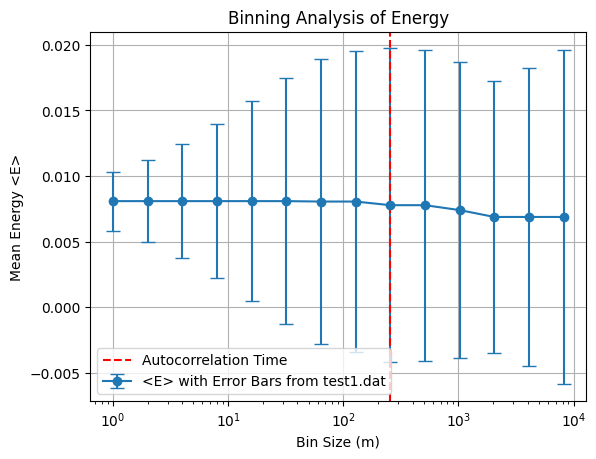

Binning analysis completed in 0.013170 seconds.

Energy binning (E):
m        <E>             Error          
1        0.017005        7.061275e-04   
2        0.017005        9.978172e-04   
4        0.017005        1.409438e-03   
8        0.017005        1.988895e-03   
16       0.017005        2.800694e-03   
32       0.017005        3.927642e-03   
64       0.017005        5.462279e-03   
128      0.016964        7.479595e-03   
256      0.016964        9.950295e-03   
512      0.016964        1.268957e-02   
1024     0.016849        1.523740e-02   
2048     0.016849        1.687099e-02   
4096     0.016849        1.860897e-02   
8192     0.016849        1.944723e-02   
16384    0.016849        1.954591e-02   
32768    0.016193        1.737243e-02   
65536    0.016193        1.525114e-02   

Autocorrelation time for test2.dat: 16384


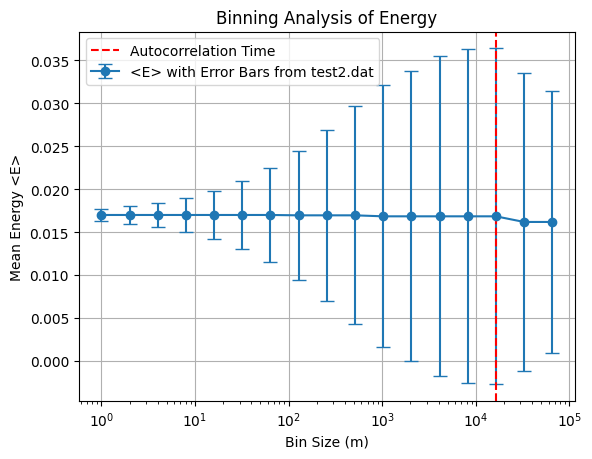

Binning analysis completed in 0.011727 seconds.

Energy binning (E):
m        <E>             Error          
1        -0.014588       7.061111e-04   
2        -0.014588       9.983879e-04   
4        -0.014588       1.411500e-03   
8        -0.014588       1.995045e-03   
16       -0.014588       2.818348e-03   
32       -0.014588       3.977088e-03   
64       -0.014588       5.599653e-03   
128      -0.014629       7.851898e-03   
256      -0.014629       1.091681e-02   
512      -0.014629       1.489937e-02   
1024     -0.014584       1.963385e-02   
2048     -0.014584       2.426555e-02   
4096     -0.014584       2.741836e-02   
8192     -0.014584       3.017616e-02   
16384    -0.014584       2.925151e-02   
32768    -0.009114       3.210422e-02   
65536    -0.009114       3.432141e-02   

Autocorrelation time for test3.dat: 8192


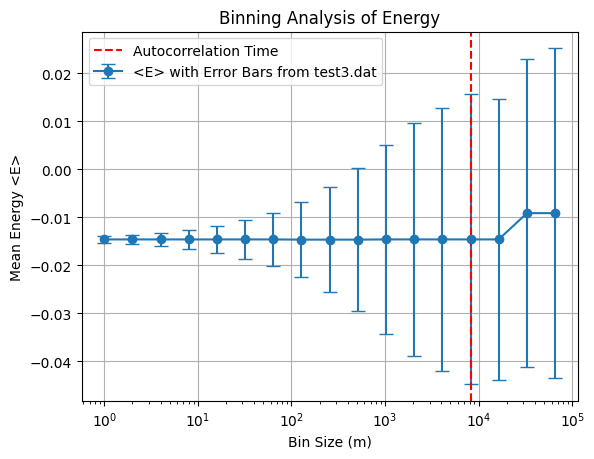

In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt

def binning_analysis(data, min_bins=100):
    """
    Optimized binning analysis using vectorized recursive averaging.
    
    Parameters:
        data: array-like, time series data
        min_bins: stop when number of bins is smaller than this (default 100)
    
    Returns:
        bin_sizes, bin_errors, bin_means
    """
    current_series = np.array(data)
    n_data = len(current_series)
    
    bin_sizes = []
    bin_errors = []
    bin_means = []
    
    m = 1
    
    # Continue until we have fewer than min_bins data points left
    while len(current_series) >= min_bins:
        # Calculate mean, standard deviation, and error for current level
        current_mean = np.mean(current_series)
        current_std = np.std(current_series, ddof=1)
        current_error = current_std / np.sqrt(len(current_series))
        
        # Store results
        bin_sizes.append(m)
        bin_means.append(current_mean)
        bin_errors.append(current_error)
        
        # Vectorized binning - using recursive averaging     
        # Truncate to even length to ensure perfect pairing
        limit = len(current_series) // 2 * 2
        # Fast numpy addition of even and odd indices
        current_series = (current_series[:limit:2] + current_series[1:limit:2]) / 2.0
        
        m *= 2
        
    return np.array(bin_sizes), np.array(bin_errors), np.array(bin_means)


def plotting_bins(bin_sizes, energy_means, energy_errors, file_name, AC_time):
    plt.errorbar(bin_sizes, energy_means, yerr=energy_errors, fmt='o-', capsize=5)
    plt.axvline(x=AC_time, color='r', linestyle='--', label='Autocorrelation Time')
    plt.xscale('log', base=10)
    plt.yscale('linear')
    plt.xlabel('Bin Size (m)')
    plt.ylabel('Mean Energy <E>')
    plt.title('Binning Analysis of Energy')
    plt.legend(['Autocorrelation Time', f'<E> with Error Bars from {file_name}'])
    plt.grid(True)
    plt.show()

for file in ['test1.dat', 'test2.dat', 'test3.dat']:

    # Run analysis
    energies = read_energies(file)
    start_time = time.time()
    bin_sizes, energy_errors, energy_means = binning_analysis(energies, min_bins=10)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Binning analysis completed in {elapsed:.6f} seconds.")
    print(f"\nEnergy binning (E):")
    print(f"{'m':<8} {'<E>':<15} {'Error':<15}")

    for m, em, err in zip(bin_sizes, energy_means, energy_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")

    if file == 'test1.dat':
        AC_time = 2 ** 8
    elif file == 'test2.dat':
        AC_time = 2 ** 14
    elif file == 'test3.dat':
        AC_time = 2 ** 13

    print(f"\nAutocorrelation time for {file}: {AC_time}")

    plotting_bins(bin_sizes, energy_means, energy_errors, file, AC_time)

In [ ]:
initial_spins, initial_energies, initial_magnetizations = run_simulation(L=4, T=5.0, mcs_steps=int(1e8))